Practicals 1: Exploring the digital chant ecosystem
===================================================

Getting our hands dirty, we will take a look around the digital chant ecosystem: the Cantus database, Cantus Index, and then we start working with the chant data contained therein. We take a look at some basic statistics of the dataset and visualise it. This will all happen in a google collab environment, so no need to install anything! All you need is an internet connection, no programming or math background required (but it may be a good idea to do a Python tutorial ahead of time).

Installing requirements
-----------------------

We need some libraries that are not installed by default.

In [1]:
!pip install scipy
!pip install matplotlib
!pip install copia
!pip install pycantus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.31.0 which is incompatible.


Getting data
------------

We work with the CantusCorpus v0.2 dataset. It is derived from the Cantus database. It contains records of almost 500,000 instances of chants, hundreds of records of manuscripts (sources), and a number of auxiliary files that encode controlled vocabularies for certain data.

CantusCorpus is somewhat dated (2020), and we are working on a more comprehensive dataset, but the advantage is that previous results for this data exist -- and especially in the context of learning, this stability is an advantage.

In [2]:
!wget https://ufallab.ms.mff.cuni.cz/~hajicj/public_html/DH-Latvia_2025/data/cantuscorpus-v0.2.zip

--2025-05-04 07:55:18--  https://ufallab.ms.mff.cuni.cz/~hajicj/public_html/DH-Latvia_2025/data/cantuscorpus-v0.2.zip
Resolving ufallab.ms.mff.cuni.cz (ufallab.ms.mff.cuni.cz)... 195.113.18.181
Connecting to ufallab.ms.mff.cuni.cz (ufallab.ms.mff.cuni.cz)|195.113.18.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51685924 (49M) [application/zip]
Saving to: ‘cantuscorpus-v0.2.zip’

cantuscorpus-v0.2.z 100%[===================>]  49.29M  20.9MB/s    in 2.4s    

2025-05-04 07:55:21 (20.9 MB/s) - ‘cantuscorpus-v0.2.zip’ saved [51685924/51685924]



In [3]:
!unzip cantuscorpus-v0.2.zip

Archive:  cantuscorpus-v0.2.zip
   creating: cantuscorpus-v0.2/
   creating: cantuscorpus-v0.2/csv/
  inflating: cantuscorpus-v0.2/csv/office.csv  
  inflating: cantuscorpus-v0.2/csv/chant-demo-sample.csv  
  inflating: cantuscorpus-v0.2/csv/indexer.csv  
  inflating: cantuscorpus-v0.2/csv/chant.csv  
  inflating: cantuscorpus-v0.2/csv/feast.csv  
  inflating: cantuscorpus-v0.2/csv/century.csv  
  inflating: cantuscorpus-v0.2/csv/orig_id.csv  
  inflating: cantuscorpus-v0.2/csv/notation.csv  
  inflating: cantuscorpus-v0.2/csv/siglum.csv  
  inflating: cantuscorpus-v0.2/csv/.feast.csv.swp  
  inflating: cantuscorpus-v0.2/csv/provenance.csv  
  inflating: cantuscorpus-v0.2/csv/genre.csv  
  inflating: cantuscorpus-v0.2/csv/source.csv  
  inflating: cantuscorpus-v0.2/.DS_Store  
   creating: cantuscorpus-v0.2/antiphons/
  inflating: cantuscorpus-v0.2/antiphons/test-chants.csv  
  inflating: cantuscorpus-v0.2/antiphons/gregobase-chantstrings.csv  
  inflating: cantuscorpus-v0.2/antiphons/

Loading CantusCorpus
--------------------

The dataset is in a CSV format, which is just a very simple way to store a table: each line of the file is a table row, and a "separator" character is defined -- usually a comma (CSV stands for comma-separated values), sometimes a tab (then it can be called TSV, tab-separated values). The file also usually has a header row that contains the names of the table columns.

Let's load all the chants first.

First, we set up the path into the dataset.

In [4]:
import os
import logging

# This is the directory into which we downloaded CantusCorpus
DATA_ROOT = 'cantuscorpus-v0.2'

# The 'chant.csv' file is where the chant data is.
DATASET_CSV_NAME = os.path.join(DATA_ROOT, 'csv', 'chant.csv')

# It is pretty good practice to check that you got key file paths right -- that the files actually exist.
if not os.path.isfile(DATASET_CSV_NAME):
    raise ValueError('CantusCorpus dataset CSV file not found at path {}. Is the DATA_ROOT set correctly?'
                     ' Current location: {}'.format(DATASET_CSV_NAME, os.getcwd()))


Now we know what file we are loading from, so we could just go ahead and use the above definition of a CSV file to read it and parse the individual lines.

But instead, we first make a small digression.

The plain-text nature of CSVs is great for interoperability and portability, and every programming language has built-in support for dealing with this type of file. That makes CSVs an excellent choice for storing and disseminating research data in repositories such as the Open Science Foundation or DARIAH-related infrastructure (e.g., LINDAT).

The minimal structure, however, comes at a cost. What happens when a text field, e.g. a manuscript description, contains the separator character (a comma)? The obvious solution is quoting. But what if the field contains a quote? These issues are what the libraries for handling CSV files resolve, at least to the extent to which it is possible. But when encoding data into CSV files, one should be aware of these issues, and ideally have a round-trip test to make sure that there is a method to load the data properly, then store it back as a CSV file, and that the resulting file has exactly the same contents as the original file.

So we actually want to use the appropriate library, and define the various parameters to load the file safely and properly.

In [5]:
# This is the library that works with CSVs in Python.
import csv

# Here we define the CSV loading parameters.
# As with the file paths, we use capital letters to clearly indicate which values
# are defined by us.
CSV_DELIMITER = ','
CSV_DOUBLEQUOTE = False
CSV_QUOTECHAR = '"'
CSV_DIALECT = 'unix'
CSV_QUOTING = csv.QUOTE_MINIMAL
# This is the policy that combines all the parameters above.
# Some of these apply when reading a CSV file, some apply when writing it back.
# The possible values of quoting policy defined and documented by the 'csv' library.

# Here is where we store all the chants, as a list.
chants = []

# Now we actually load them!
# This can take a while, as there are almost half a million of them.
with open(DATASET_CSV_NAME) as fh:
    reader = csv.DictReader(fh,
                            delimiter=CSV_DELIMITER,
                            doublequote=CSV_DOUBLEQUOTE,
                            quotechar=CSV_QUOTECHAR,
                            dialect=CSV_DIALECT,
                            quoting=CSV_QUOTING)

    # At this point, we could just load the data, but because we want
    # to be very sure that we have been able to load the data properly,
    # we wrap it with this 'try-except' construction. This means:
    # If an error happens during the 'try' block, jump into the 'except'
    # block to deal with it. In this case, we simply want to know which row
    # the error occurred in, so that we know which line of the data file
    # we should check for errors.
    try:
        for i, row in enumerate(reader):
            chants.append(row)
    except:
        print('Row {} has an error!\nRow: {}'.format(i, row))
        raise

# We also want to remember what the field names are, to be able to quickly check
# what information is available for each chant.
fieldnames = reader.fieldnames


Let's check how many chants exactly we got:

In [6]:
n_chants = len(chants)
print('Loaded {} chants.'.format(n_chants))

Loaded 497071 chants.


And what information is available for each of the chants:

In [7]:
print(fieldnames)

['id', 'incipit', 'cantus_id', 'mode', 'finalis', 'differentia', 'siglum', 'position', 'folio', 'sequence', 'marginalia', 'cao_concordances', 'feast_id', 'genre_id', 'office_id', 'source_id', 'melody_id', 'drupal_path', 'full_text', 'full_text_manuscript', 'volpiano', 'notes']


In [8]:
# Let's print it out a little better...
print('\n'.join(fieldnames))

id
incipit
cantus_id
mode
finalis
differentia
siglum
position
folio
sequence
marginalia
cao_concordances
feast_id
genre_id
office_id
source_id
melody_id
drupal_path
full_text
full_text_manuscript
volpiano
notes


So what does a chant record look like?

In [9]:
print(chants[0])

{'id': 'chant_000001', 'incipit': '#ne positi certamen habuistis mercedem', 'cantus_id': '007590.1', 'mode': '', 'finalis': '', 'differentia': '', 'siglum': 'US-HA Rauner Codex MS 003203', 'position': '', 'folio': '066r', 'sequence': '0.0', 'marginalia': '', 'cao_concordances': '', 'feast_id': 'feast_0227', 'genre_id': 'genre_r', 'office_id': 'office_m', 'source_id': 'source_519', 'melody_id': '', 'drupal_path': 'http://cantus.uwaterloo.ca/chant/693173/', 'full_text': '#ne positi certamen habuistis mercedem laboris ego reddam vobis', 'full_text_manuscript': '#ne positi certamen habuistis | Mercedem laboris ego reddam vobis', 'volpiano': '', 'notes': ''}


In [10]:
# This is not really readable. Let'd define a function for this:
def print_chant(chant, fieldnames=fieldnames):
  for f in fieldnames:

    # Check that the field name that we expect is actually available in the chant record
    if f not in chant:
      # This would be a basic error message:
      #raise ValueError('Chant does not contain field name {}!'.format(f))
      # This is a better error message, because it shows both the problematic field name
      # and the chant record, so that you can straight away start diagnosing where the problem is.
      raise ValueError('Chant does not contain field name {}!\n'
                       'Available fields: {}'.format(f, list(chant.keys())))
    value = chant[f]
    print('{}: {}'.format(f, value))

In [11]:
print_chant(chants[0])

id: chant_000001
incipit: #ne positi certamen habuistis mercedem
cantus_id: 007590.1
mode: 
finalis: 
differentia: 
siglum: US-HA Rauner Codex MS 003203
position: 
folio: 066r
sequence: 0.0
marginalia: 
cao_concordances: 
feast_id: feast_0227
genre_id: genre_r
office_id: office_m
source_id: source_519
melody_id: 
drupal_path: http://cantus.uwaterloo.ca/chant/693173/
full_text: #ne positi certamen habuistis mercedem laboris ego reddam vobis
full_text_manuscript: #ne positi certamen habuistis | Mercedem laboris ego reddam vobis
volpiano: 
notes: 


In [12]:
# And another chant:
print_chant(chants[123000])

id: chant_123001
incipit: Dixerunt impii apud se non
cantus_id: 006464
mode: 
finalis: 
differentia: 
siglum: CZ Pu VI.E.4c
position: 1.2
folio: 230r
sequence: 1.0
marginalia: 
cao_concordances: CGBEMVHRDFSL
feast_id: feast_0643
genre_id: genre_r
office_id: office_m
source_id: 
melody_id: 
drupal_path: http://cantus.uwaterloo.ca/chant/464369/
full_text: Dixerunt impii apud se non recte cogitantes circumveniamus justum quoniam contrarius est operibus nostris promittit se scientiam dei habere filium dei se nominat et gloriatur patrem se habere deum videamus si sermones illius veri sint et si est verus filius dei liberet illum de manibus nostris morte turpissima condempnemus eum
full_text_manuscript: 
volpiano: 
notes: 


**Digression no. 2: Fixing the URLs**

Notice that when we click the `drupal_path` link, it does not work. This is because the Cantus Database has undergone a change of URL in 2023, and the `cantus.uwaterloo.ca` server stopped redirecting, too. So, to make it easier for us to check things, we will change these values in our chants.

In [13]:
for c in chants:
  old_drupal_path = c['drupal_path']
  fixed_drupal_path = old_drupal_path.replace('http://cantus.uwaterloo.ca', 'https://cantusdatabase.org').rstrip('/')
  c['drupal_path'] = fixed_drupal_path

Now the URLs should work.

In [36]:
print_chant(chants[123000])

id: chant_123001
incipit: Dixerunt impii apud se non
cantus_id: 006464
mode: 
finalis: 
differentia: 
siglum: CZ Pu VI.E.4c
position: 1.2
folio: 230r
sequence: 1.0
marginalia: 
cao_concordances: CGBEMVHRDFSL
feast_id: feast_0643
genre_id: genre_r
office_id: office_m
source_id: 
melody_id: 
drupal_path: https://cantusdatabase.org/chant/464369
full_text: Dixerunt impii apud se non recte cogitantes circumveniamus justum quoniam contrarius est operibus nostris promittit se scientiam dei habere filium dei se nominat et gloriatur patrem se habere deum videamus si sermones illius veri sint et si est verus filius dei liberet illum de manibus nostris morte turpissima condempnemus eum
full_text_manuscript: 
volpiano: 
notes: 


Issues such as this are why we should care very much about persistence and long-term storage in the digital humanities. Cantus Database and its whole network gets almost everything right -- but still these issues are inevitable, because the digital environment evolves very quickly.

Counting chants
---------------

497,071 chants is a bit much to inspect manually, though, so we get some idea about what is really in this data by extracting some basic descriptive statistics.

We know we have catalogued this huge amount of chants, but many of these will be copies of the same repertoire across many manuscripts. So, how many discint chants do we have in the catalogued repertoire?

This can be done thanks to the essential Cantus ID mechanism. Instances of the same chant across different manuscripts have the same Cantus ID assigned.



In [14]:
all_cantus_ids = set(c['cantus_id'] for c in chants)  # The set() is a construction to only retain one instance of each value.
n_distinct_chants = len(all_cantus_ids)
print('{} distinct chants available.'.format(n_distinct_chants))


31501 distinct chants available.


So on average, we can expect to see each Cantus ID:

In [15]:
n_chants / n_distinct_chants

15.779530808545761

But of course averages are not terribly informative. What we probably want to really know is the frequency profile of Cantus IDs: how many appear only once, how many appear twice, and how many are on the other hand of the spectrum, appearing tens or even hundreds of times.

In [16]:
cid_frequencies = {}  # We can use 'cid' as the abbreviation for Cantus ID. It is sufficiently distinct.
for chant in chants:
  cid = chant['cantus_id']
  if cid not in cid_frequencies:
    cid_frequencies[cid] = 0
  cid_frequencies[cid] += 1   # '+=' means 'add and modify original'. It's shorthand for cid_frequencies[cid] = cid_frequencies[cid] + 1

Now we know how often each Cantus ID appeared in the dataset, but printing a dictionary of 31,000+ entries is also not helpful. But what we can do is visualise. For this, the `matplotlib` library is the most widespread and best-documented for Python.

(Generally when you need to pick a library out of several choices that all support the features you require, go for the one that is most widely used. When you encounter some issue, the more users a library has, the more likely it is that someony has already had that issue and got it resolved, either through StackOverflow or some other publicly available forum.)

In [17]:
import matplotlib.pyplot as plt
# This is a magical shortcut for making sure the visualisatons will be plotted nicely directly in the notebook:
%matplotlib inline

In [18]:
# Let's just plot the Cantus ID frequencies, sorted from highest to lowest.

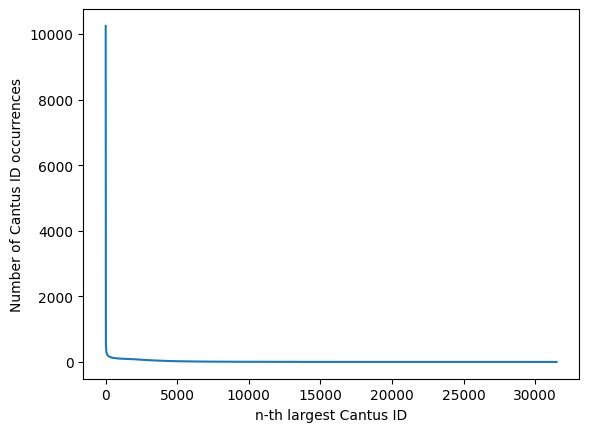

In [19]:
cid_frequencies_sorted = list(sorted(cid_frequencies.values(), reverse=True))  # sorted() by default goes from lowest to highest

plt.plot(cid_frequencies_sorted)
plt.xlabel('n-th largest Cantus ID')   # Best practice: always label both axes.
plt.ylabel('Number of Cantus ID occurrences')
plt.show()

Something is wrong: the most frequent Cantus ID occurred more than 10000 times, which makes the rest of the plot rather uninformative. This is very likely a case of missing data --- records with no Cantus ID present, which get loaded as an empty string. Let's see:

In [20]:
cid_frequencies['']

10244

Yes, that was it. Let's re-compute the frequencies while accounting for this:



In [21]:
n_empty_cids = 0
cid_frequencies = {}  # We can use 'cid' as the abbreviation for Cantus ID. It is sufficiently distinct.
for chant in chants:
  cid = chant['cantus_id']

  if cid == '':   # Here we deal with the missing values: just document how many there are.
    n_empty_cids += 1
    continue

  if cid not in cid_frequencies:
    cid_frequencies[cid] = 0
  cid_frequencies[cid] += 1   # '+=' means 'add and modify original'. It's shorthand for cid_frequencies[cid] = cid_frequencies[cid] + 1

Now we plot the CID counts again:

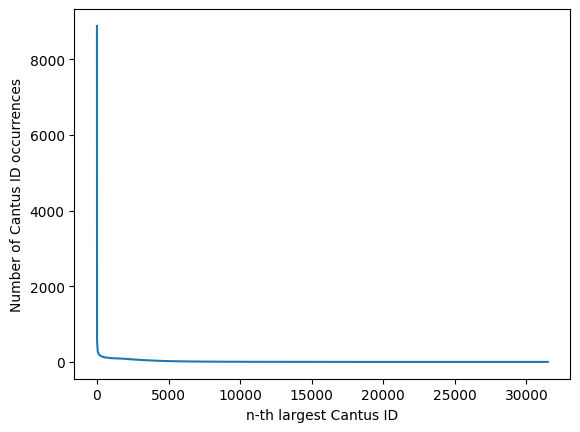

In [22]:
cid_frequencies_sorted = list(sorted(cid_frequencies.values(), reverse=True))  # sorted() by default goes from lowest to highest

plt.plot(cid_frequencies_sorted)
plt.xlabel('n-th largest Cantus ID')   # Best practice: always label both axes.
plt.ylabel('Number of Cantus ID occurrences')
plt.show()

...and we still have some problem! It was not just the empty ones.
Let's see the highest-frequency values.

In [23]:
cid_and_frequency_pairs_sorted = list(
    sorted(cid_frequencies.items(),    # The .items() function of a dictionary returns an iterator over all key-value pairs
           reverse=True,               # We still want to go from highest to lowest
           key=lambda kv: kv[1]        # ...so we have to sort by the *value* part of the (key, value) pair.
           )
    )                                  # Finally, we turn the whole thing into a regular list,
                                       # to not have to deal with some Python efficiency magic on sorted() and .items().

In [24]:
cid_and_frequency_pairs_sorted[:10]

[('909000', 8883),
 ('008097', 908),
 ('008081', 867),
 ('001328', 840),
 ('909030', 796),
 ('008201', 750),
 ('008014', 719),
 ('008120', 666),
 ('008301', 593),
 ('007941', 565)]

OK, `909000` looks like a legitimate Cantus ID. What chant does it represent?

In [25]:
chants_with_909000 = [c for c in chants if c['cantus_id'] == '909000']

In [26]:
chants_with_909000[0]

{'id': 'chant_000564',
 'incipit': '-loria patri et filio et',
 'cantus_id': '909000',
 'mode': '1',
 'finalis': '',
 'differentia': '',
 'siglum': 'HR-Dsmbb XI',
 'position': '02',
 'folio': '125r',
 'sequence': '1.0',
 'marginalia': '',
 'cao_concordances': '',
 'feast_id': 'feast_0577',
 'genre_id': 'genre_v',
 'office_id': 'office_m',
 'source_id': '',
 'melody_id': '',
 'drupal_path': 'https://cantusdatabase.org/chant/279117',
 'full_text': '',
 'full_text_manuscript': '',
 'volpiano': '',
 'notes': ''}

In [27]:
chants_with_909000[1]

{'id': 'chant_139928',
 'incipit': 'Doxa patri et filio et',
 'cantus_id': '909000',
 'mode': '8S',
 'finalis': '',
 'differentia': '',
 'siglum': 'SI-Lna 18 (olim 17)',
 'position': '02',
 'folio': '185v',
 'sequence': '2.0',
 'marginalia': '',
 'cao_concordances': '',
 'feast_id': 'feast_0888',
 'genre_id': 'genre_v',
 'office_id': 'office_m',
 'source_id': 'source_236',
 'melody_id': '',
 'drupal_path': 'https://cantusdatabase.org/chant/344226',
 'full_text': '',
 'full_text_manuscript': '',
 'volpiano': '',
 'notes': ''}

In [28]:
chants_with_909000[2]

{'id': 'chant_173090',
 'incipit': 'Et gloria*',
 'cantus_id': '909000',
 'mode': '*',
 'finalis': '',
 'differentia': '',
 'siglum': 'A-Wn Mus.Hs.15489',
 'position': '02',
 'folio': '040r',
 'sequence': '7.0',
 'marginalia': '',
 'cao_concordances': '',
 'feast_id': 'feast_0552',
 'genre_id': 'genre_v',
 'office_id': 'office_m',
 'source_id': '',
 'melody_id': '',
 'drupal_path': 'https://cantusdatabase.org/chant/572245',
 'full_text': 'Et gloria*',
 'full_text_manuscript': '{Et gloria}',
 'volpiano': '',
 'notes': ''}

It's the **doxology**!

This is a great example of how the interaction between domain knowledge and computing skills is necessary. These are legitimate chant records: they have all the required information, they have a valid Cantus ID, they record what manuscript they come from, etc. So, those are not mistakes, in the sense in which the empty Cantus ID records were invalid.

What to do? Should we actually treat this as the most frequent Cantus ID? Should it participate in computing the average number of chants per Cantus ID? (Incidentally, the invalid records with no Cantus ID participated in that average as well.)

Here is where domain knowledge comes in. The doxology is the phrase:

_'Gloria Patri et Filii et Spiritui Sancto_

_sicut erat in principio et nunc et semper, et in saecula saeculorum. Amen.'_

which is added at the end of every psalm, and into many other chants, esp. those genres that use psalm verses as their texts. The doxology is not recorded too often, but because it occurs so many times in liturgy, when scribal practices of a certain time and place included recording the doxology as a separate unit (even if just in some contexts), then its frequency skyrockets.

So for the purpose of obtaining useful descriptive statistics, the doxology is not too helpful. Let's exclude it.

We can implement this via keeping a list of excluded Cantus IDs:

In [29]:
# Again we write the variable name in capitals, because it is something we set "from above".
EXCLUDED_CANTUS_IDS = ['',
                       '909000']  # Doxology

In [30]:
# And we re-do the frequency counting
n_empty_cids = 0
n_excluded_cids = 0
cid_frequencies = {}  # We can use 'cid' as the abbreviation for Cantus ID. It is sufficiently distinct.
for chant in chants:
  cid = chant['cantus_id']

  if cid in EXCLUDED_CANTUS_IDS:   # Updated from only missing values to all excluded values
    n_excluded_cids += 1
    if cid == '':
      n_empty_cids += 1    # We still want to document empty Cantus IDs, to perhaps do some data quality work later.
    continue

  if cid not in cid_frequencies:
    cid_frequencies[cid] = 0
  cid_frequencies[cid] += 1   # '+=' means 'add and modify original'. It's shorthand for cid_frequencies[cid] = cid_frequencies[cid] + 1

In [33]:
print('Total distinct CIDs (exclusions applied): {}\nChants with excluded CIDs: {}, of those empty CIDs: {}'
      ''.format(len(cid_frequencies), n_excluded_cids, n_empty_cids))

# We also have to adjust the basic statistics we are going to use down the road.
n_distinct_chants = len(cid_frequencies)
n_chants = n_chants - n_excluded_cids
print('Average no. of chants per CID: {:.2f}'.format(n_chants / n_distinct_chants))

Total distinct CIDs (exclusions applied): 31499
Chants with excluded CIDs: 19127, of those empty CIDs: 10244
Average no. of chants per CID: 14.57


And we re-do the plotting:

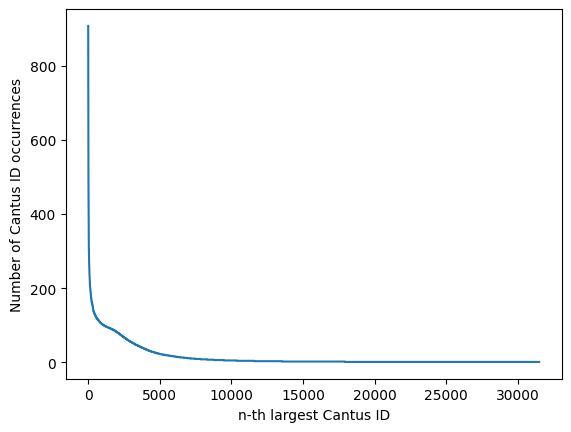

In [34]:
cid_frequencies_sorted = list(sorted(cid_frequencies.values(), reverse=True))  # sorted() by default goes from lowest to highest

plt.plot(cid_frequencies_sorted)
plt.xlabel('n-th largest Cantus ID')   # Best practice: always label both axes.
plt.ylabel('Number of Cantus ID occurrences')
plt.show()

These are suddenly more reasonable numbers! We know that the Cantus database contains a few hundred sources at most, and some very frequent chants can occur multiple times within a source, so having some very small number of chants that have frequencies like 500 or even 900 is probably not a mistake or not something strange that would require excluding the Cantus ID.

But we should certainly check again, just to be sure!

Let's re-compute the list of most frequent Cantus IDs and their frequencies:

In [35]:
cid_and_frequency_pairs_sorted = list(
    sorted(cid_frequencies.items(),    # The .items() function of a dictionary returns an iterator over all key-value pairs
           reverse=True,               # We still want to go from highest to lowest
           key=lambda kv: kv[1]        # ...so we have to sort by the *value* part of the (key, value) pair.
           )
    )                                  # Finally, we turn the whole thing into a regular list,
                                       # to not have to deal with some Python efficiency magic on sorted() and .items().

In [36]:
cid_and_frequency_pairs_sorted[:10]

[('008097', 908),
 ('008081', 867),
 ('001328', 840),
 ('909030', 796),
 ('008201', 750),
 ('008014', 719),
 ('008120', 666),
 ('008301', 593),
 ('007941', 565),
 ('007994', 555)]

Again we take a look at what the most frequent Cantus ID represents:

In [37]:
chants_with_008097 = [c for c in chants if c['cantus_id'] == '008097']
for i in range(3):
  # print(chants_with_008097[i])    # This is hard to read. But we have the convenient print_chant() function defined earlier!
  print_chant(chants_with_008097[i])
  print('-----')  # Because print_chant() does not separate between the printed records...

id: chant_241753
incipit: In omnem fratem*
cantus_id: 008097
mode: *
finalis: 
differentia: 
siglum: CDN-Hsmu M2149.L4
position: 1.
folio: 180r
sequence: 2.0
marginalia: 
cao_concordances: 
feast_id: feast_0180
genre_id: genre_w
office_id: office_m
source_id: source_297
melody_id: 
drupal_path: https://cantusdatabase.org/chant/272330
full_text: In omnem fratem*
full_text_manuscript: In omnem fratem
volpiano: 
notes: 
-----
id: chant_241756
incipit: In omnem terra*
cantus_id: 008097
mode: *
finalis: 
differentia: 
siglum: US-Cn 24
position: R
folio: 072r
sequence: 5.0
marginalia: A
cao_concordances: C BEMVHRD SL
feast_id: feast_1607
genre_id: genre_w
office_id: office_l
source_id: source_072
melody_id: 
drupal_path: https://cantusdatabase.org/chant/220918
full_text: 
full_text_manuscript: 
volpiano: 
notes: 
-----
id: chant_241761
incipit: In omnem terram
cantus_id: 008097
mode: 
finalis: 
differentia: 
siglum: CZ Pu VI.E.4c
position: 1.
folio: 083r
sequence: 7.0
marginalia: 
cao_concor

It turns out that this is a versicle (genre: W) for the Divine Office when there is a feast scheduled in the liturgical calendar that has something to do with an apostle (Peter, John, Mark, Thomas, etc.). No wonder that it is very frequent. But this is no anomaly. It should stay in the database.

**Digression 3: Aggregating information from chant records**

When we inspected the record above, not all records of the chant across different manuscripts actually corresponded to the same liturgical position. We have a 'hard' expectation that chants from the same Cantus ID all belong to the same genre. We expect chants from different manuscripts to of course not have the same siglum, folio, or other attributes connected to the manuscript itself.

But then there are liturgical properties like which feast a chant is used for, which office and which position it occupies within that office. These have often been used to identify different "uses" or "sub-traditions". For instance, monastic orders could have differed in what chants they chose e.g. for Marian feasts.

This variability might be reflected for some Cantus IDs in that these properties vary a lot across the different instances of the given chant in manuscripts. Again, however, this is not something we can really inspect manually at this scale: finding such chants calls for automation.

Though it is not easy to define what is a 'sufficiently varied' use of a chant, the first step towards this is simply **aggregating chants that share a Cantus ID**. (We may already want this in the same way that Cantus Index wants this: to be able to say at least which single value represents each field of a chant the most.)

For this purpose, we define a new abstraction above the dataset. For the lack of a better term, we call this a **work** (though of course for Gregorian chant this is quite a poor designation...).

Programming practices dictate that new complex entities derived from our dataset should be implemented as classes. (Representing "things" is exactly what object-oriented programming was born to do!)

In [38]:
class Work:

  ALL_CHANT_FIELDS = fieldnames

  # Aggregation policies
  # --------------------

  # Here we define how we handle aggregation of the different fields
  # available for each chant record.

  # These fields we cannot aggregate, because they are by definition
  # unique to a chant's instance in a manuscript.
  MANUSCRIPT_FIELDS = ['siglum', 'sequence', 'folio', 'marginalia', 'source_id', 'drupal_path',
                       'full_text_manuscript',
                       'volpiano',              # Melodies are practically never the same and exctracting a characteristic melody
                                                # is what Solesmes does for the last 150 years or so.
                       'notes']

  # These fields we expect to have a variety of values, and we are interested
  # in the characteristic value of these.
  CHARACTERISTIC_FIELDS = ['incipit', 'genre_id', # We include genre here, even though it should be single-value, for reporting.
                           'mode', 'finalis', 'differentia',
                           'position',   # 'position' is liturgical position, 'sequence' is position on the page
                           'office_id', 'feast_id'
                           ]

  # These fields are expected to only have a single value and if they don't
  # the Work cannot be constructed.
  SINGLE_VALUE_ENFORCED_FIELDS = ['cantus_id']

  # Those should be consistent, but we allow them to be also empty
  # and if they are not consistent we do not care as much.
  SINGLE_VALUE_OR_EMPTY_FIELDS = ['genre_id', 'full_text', 'cao_concordances']

  # These fields have no point for a Work.
  IGNORED_FIELDS = ['melody_id', 'id']


  def __init__(self, chants):       # In Python, __init__() is a special function that is run when a new object of that class is created.
                                    # The 'self' parameter always refers to the current instance of the class.

    # Check that we got at least some chants
    if len(chants) == 0:
      raise ValueError('Work must have at least one chant!')

    # Check that all the chants really have the same Cantus ID
    all_cantus_ids = set(c['cantus_id'] for c in chants)
    if len(all_cantus_ids) >= 2:   # More than 1 Cantus ID
      raise ValueError('A Work cannot be built from chants with different Cantus IDs!'
                       ' Tried to construct work with Cantus IDs: {}'.format(all_cantus_ids))

    self.chants = chants
    self.cantus_id = self.chants[0]['cantus_id']

    # Now we compute and store the characteristic values
    self.characteristic_values = {}
    self.characteristic_freqdicts = {}
    for f in self.CHARACTERISTIC_FIELDS:
       characteristic_value, characteristic_freqdict = self.determine_characteristic_value_and_freqdict(f)
       self.characteristic_values[f] = characteristic_value
       self.characteristic_freqdicts[f] = characteristic_freqdict

    # We actually leave the policy for single-value-or-empty fields
    # not implemented for now, it's not important for the rest of the notebook.
    # (This is actually a real software development practice. Defining
    #  what something is supposed to do is often much more important than
    #  actually implementing that functionality.)


  def __len__(self):   # The __str__(self) special method determines how the class reacts to len(work)
    return len(self.chants)

  def __str__(self):   # The __str__(self) special method determines how the class reacts to print(work)
    header_string = 'Work CID {}: {} chants, characteristics:'.format(self.cantus_id, len(self))
    characteristic_strings = ['\t{}:\t{}'.format(f, self.characteristic_values[f])
                              for f in self.CHARACTERISTIC_FIELDS]
    characteristic_string = '\n'.join(characteristic_strings)
    output = header_string + '\n' + characteristic_string
    return output


  def determine_characteristic_value_and_freqdict(self, field):
    """Return the characteristic (most frequent) value for the given field
    across all the work's chants. In case of a tie, returns a random value
    from the tied highest-frequency value set.

    Also return a frequency dictionary of all values for that field."""

    # Guarding against invalid input. This is in some sense unnecessary, but it can save painful debugging.
    if field not in self.ALL_CHANT_FIELDS:
      raise ValueError('Invalid field: {}! Available fields: {}'.format(field, self.ALL_CHANT_FIELDS))

    most_frequent_values = set()   # There may be a tie for the highest-frequency value
    highest_frequency = -1

    value_frequencies = {}
    for c in self.chants:
      v = c[field]

      # Accumulating the freuqency dictionary
      if v not in value_frequencies:
        value_frequencies[v] = 0
      value_frequencies[v] += 1

      # Keeping track of the characteristic value
      current_frequency = value_frequencies[v]
      if current_frequency == highest_frequency:
        most_frequent_values.add(v)
      elif current_frequency > highest_frequency:
        most_frequent_values = set([v])
        highest_frequency = current_frequency

    # We actually don't bother with the ties for now when returning a value for now...
    return list(most_frequent_values)[0], value_frequencies

And we define also a convenience function to create works from a list of chants and a Cantus ID:

In [39]:
def create_work(cantus_id, chants):
  relevant_chants = [c for c in chants if c['cantus_id'] == cantus_id]
  work = Work(chants=relevant_chants)
  return work

Let's try it out!

In [40]:
work_003511 = create_work('003511', chants)   # Cantus IDs often look like numbers, but they are always strings.

In [41]:
print(work_003511)

Work CID 003511: 132 chants, characteristics:
	incipit:	Judaea et Jerusalem nolite
	genre_id:	genre_a
	mode:	8
	finalis:	
	differentia:	G1
	position:	1
	office_id:	office_l
	feast_id:	feast_1765


We can inspect the distribution of values for the individual characteristic fields:

In [42]:
work_003511.characteristic_freqdicts['office_id']

{'office_l': 95,
 'office_v2': 10,
 'office_v': 12,
 'office_p': 14,
 'office_t': 1}

In [43]:
work_003511.characteristic_freqdicts['mode']

{'8': 90, '': 9, '?': 8, '*': 22, 'Gc': 1, '8*': 1, '5': 1}

In [44]:
work_003511.characteristic_freqdicts['differentia']

{'G1': 36,
 '': 32,
 '1': 21,
 '2': 2,
 'w': 7,
 'G2': 7,
 '*': 16,
 'G5': 1,
 '?': 3,
 'G01': 2,
 'G': 4,
 '33c': 1}

In [45]:
work_003511.characteristic_freqdicts['position']

{'1': 111, '4': 1, '': 20}

Now we have a convenient way of characterising what individual Cantus IDs stand for. This is similar to what the user interface of Cantus Index does. (End of digression.)

---



**Now we get back to the most frequent Cantus IDs.** We can apply the Work class straight away to inspect the top 10 most frequent CIDs.

In [46]:
top_10_cids = [cf[0] for cf in cid_and_frequency_pairs_sorted[:10]]

In [47]:
for cid in top_10_cids:
  work = create_work(cid, chants)
  print(work)

Work CID 008097: 908 chants, characteristics:
	incipit:	In omnem terram*
	genre_id:	genre_w
	mode:	*
	finalis:	
	differentia:	
	position:	
	office_id:	office_m
	feast_id:	feast_0198
Work CID 008081: 867 chants, characteristics:
	incipit:	Gloria et honore*
	genre_id:	genre_w
	mode:	*
	finalis:	
	differentia:	
	position:	
	office_id:	office_m
	feast_id:	feast_0258
Work CID 001328: 840 chants, characteristics:
	incipit:	Alleluia iii
	genre_id:	genre_a
	mode:	8
	finalis:	
	differentia:	*
	position:	
	office_id:	office_m
	feast_id:	feast_0473
Work CID 909030: 796 chants, characteristics:
	incipit:	Venite exsultemus domino
	genre_id:	genre_ip
	mode:	
	finalis:	
	differentia:	
	position:	
	office_id:	office_m
	feast_id:	feast_0966
Work CID 008201: 750 chants, characteristics:
	incipit:	Specie tua*
	genre_id:	genre_w
	mode:	*
	finalis:	
	differentia:	
	position:	
	office_id:	office_m
	feast_id:	feast_0234
Work CID 008014: 719 chants, characteristics:
	incipit:	Diffusa est gratia*
	genre_id:	ge

Nothing particularly suspicious in here. We don't have to exclude anything else.

So, we can finally get back to plotting the frequencies of Cantus IDs!

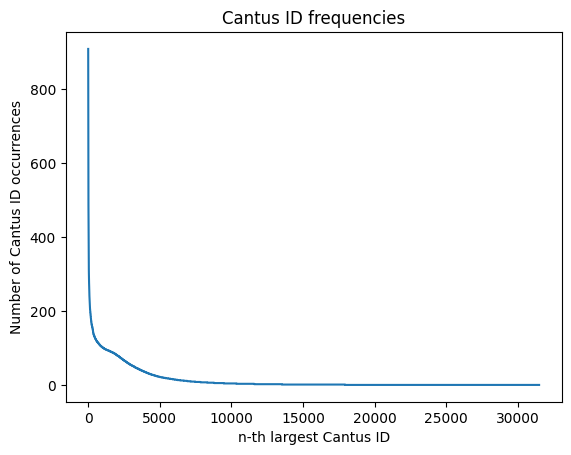

In [48]:
cid_frequencies_sorted = list(sorted(cid_frequencies.values(), reverse=True))  # sorted() by default goes from lowest to highest

# We use matplotlib here in a slightly different, more flexible way:
# we work directly with its "axes" object rather than just calling plt.something()
# functions. The reason will soon become apparent.

ax = plt.gca()
ax.plot(cid_frequencies_sorted)
ax.set_title('Cantus ID frequencies')
ax.set_xlabel('n-th largest Cantus ID')   # Best practice: always label both axes.
ax.set_ylabel('Number of Cantus ID occurrences')

plt.show()

Now let's plot this figure but with the frequency axis logarithmic.

This helps with making the structure of this long tail clearer.

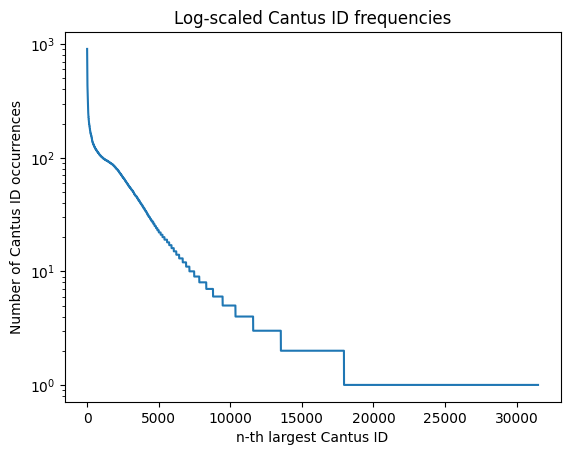

In [49]:

ax = plt.gca()
ax.plot(cid_frequencies_sorted)
ax.set_title('Log-scaled Cantus ID frequencies')
ax.set_xlabel('n-th largest Cantus ID')   # Best practice: always label both axes.
ax.set_ylabel('Number of Cantus ID occurrences')
ax.set_yscale('log')

plt.show()

Liturgies and Genres
====================

What is that 'bump' just under 100 occurences of a Cantus ID, around the 2000th-2500th most frequent CID?

In order to address this, we must look deeper into the contents of the dataset. Right now we are mixing chants for two non-overlapping liturgies: the Mass, and the Divine Office. These are in fact overwhelmingly written in different types of medieval manuscripts -- Antiphoners (and notated Breviaries) for the Office, and Graduals (and notated Missals) for the Mass. This material difference illustrates the distinction between these two elementary types of Latin liturgy.

We should thereofre probably analyse chants for the Mass and for the Office separately. There are two ways to distinguish which liturgy a chant belongs to in Cantus: the `office_id`, and the `genre_id`. But, the `office_id` has had a somewhat inconsistent cataloguing history, while the genres are applied much more rigorously in Cantus, and each genre of chant by definition belongs to only one of these liturgies. Additionally, each genre corresponds to a particular liturgical position and thus a purpose that the practitioners had for the given group of chants, and genres have proven very useful in identifying e.g. use -- focusing on *alleluias* rather than *offertories*, for instance, is much more fruitful in determining what ecclesiastical context a manuscript might be coming from.

So, we aggregate chants into groups by their genre: antiphons, responsories etc.



In [50]:
fieldnames

['id',
 'incipit',
 'cantus_id',
 'mode',
 'finalis',
 'differentia',
 'siglum',
 'position',
 'folio',
 'sequence',
 'marginalia',
 'cao_concordances',
 'feast_id',
 'genre_id',
 'office_id',
 'source_id',
 'melody_id',
 'drupal_path',
 'full_text',
 'full_text_manuscript',
 'volpiano',
 'notes']

TODOs
-----

- Add a "feast code translator", mostly to Work printout.
- What is that bump?
- Split chants by genre.
- Plot this for individual genres (into the same plot?) for Office and Mass.
